<a href="https://colab.research.google.com/github/ryanreilly/phase_5_capstone/blob/main/DenseNet121_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load the data from my google drive
from google.colab import drive
!unzip drive/MyDrive/train.zip
!unzip drive/MyDrive/dev.zip
!unzip drive/MyDrive/test.zip

In [ ]:
#This is to see what GPU Google gave me
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [3]:
#Set directories
train_dir = 'train'
validation_dir = 'dev'
test_dir = 'test'

In [4]:
#For manipulating and visualizing images
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#To load an image using Keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import optimizers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model, load_model, save_model

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

#to track how long the models run
import datetime

#For dividing the images into correct folders
import shutil
import os

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
            
validation_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
#Create train and validation generators
train_generator_dense = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(240, 240),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator_dense = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(240, 240), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.


In [8]:
#Build the model
Densenet = DenseNet121(
    input_shape= (224,224,3),
    include_top=False,
    weights='imagenet')


Densenet.trainable = False

# Define Model Architecture
X = Densenet.output
X = GlobalAveragePooling2D()(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
X = Dense(1024,activation='relu')(X) 
X = Dense(512,activation='relu')(X) 
X = BatchNormalization()(X)
X = Dropout(0.5)(X)
outputs = Dense(7, activation='softmax')(X)

model_dense = Model(Densenet.input, outputs)


opt = optimizers.Adam(learning_rate=0.00001)
model_dense.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


history_6= model_dense.fit_generator(generator= train_generator_dense,
                                    epochs= 60, 
                                    validation_data= validation_generator_dense, 
                                    validation_steps=1)

Epoch 1/60
389/389 [==============================] - 300s 720ms/step - loss: 2.7640 - accuracy: 0.2129 - val_loss: 1.1823 - val_accuracy: 0.5938
Epoch 2/60
389/389 [==============================] - 279s 716ms/step - loss: 2.2335 - accuracy: 0.3375 - val_loss: 0.8007 - val_accuracy: 0.8125
Epoch 3/60
389/389 [==============================] - 279s 716ms/step - loss: 2.0297 - accuracy: 0.3953 - val_loss: 0.6280 - val_accuracy: 0.8750
Epoch 4/60
389/389 [==============================] - 277s 713ms/step - loss: 1.9299 - accuracy: 0.4229 - val_loss: 0.5685 - val_accuracy: 0.8750
Epoch 5/60
389/389 [==============================] - 278s 714ms/step - loss: 1.8126 - accuracy: 0.4570 - val_loss: 0.5189 - val_accuracy: 0.8438
Epoch 6/60
389/389 [==============================] - 278s 715ms/step - loss: 1.7697 - accuracy: 0.4737 - val_loss: 0.5056 - val_accuracy: 0.8750
Epoch 7/60
389/389 [==============================] - 276s 710ms/step - loss: 1.7093 - accuracy: 0.4927 - val_loss: 0.4940 -

In [9]:
model_dense.save('model_dense2.h5') 

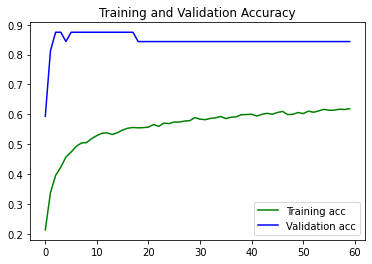

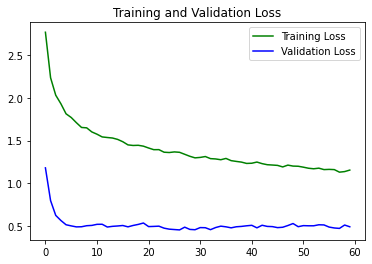

In [42]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
#Build test generator
test_generator_dense = test_datagen.flow_from_directory(test_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 3147 images belonging to 7 classes.


In [36]:
#Create predictions
y_pred = model_dense.predict(test_generator_dense)

In [37]:
y_pred = np.argmax(y_pred, axis=1)

In [38]:
def plot_confusion_mat(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
cm = confusion_matrix(test_generator_dense.classes, y_pred)
cm_plot_labels = [key for key,value in test_generator_dense.class_indices.items()]

Confusion matrix, without normalization


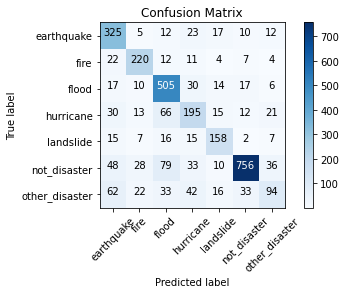

In [40]:
plot_confusion_mat(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [15]:
print(classification_report(test_generator_dense.classes, y_pred, target_names = [key for key,value in test_generator_dense.class_indices.items()]))

                precision    recall  f1-score   support

    earthquake       0.63      0.80      0.70       404
          fire       0.72      0.79      0.75       280
         flood       0.70      0.84      0.76       599
     hurricane       0.56      0.55      0.56       352
     landslide       0.68      0.72      0.70       220
  not_disaster       0.90      0.76      0.83       990
other_disaster       0.52      0.31      0.39       302

      accuracy                           0.72      3147
     macro avg       0.67      0.68      0.67      3147
  weighted avg       0.72      0.72      0.71      3147

